## Part 1: preparing data

Load pixel data from CSV file.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random


img_size = 28
mnist_data = pd.read_csv('./mnist.csv').values
labels = mnist_data[:, 0]
digits = mnist_data[:, 1:]      # DATA: raw digits data

#### Resizing the image

After multiple attempts at fitting the model, it was observed that the required time for the model to converge was too expensive (in one instance, it does not converge even after 2 hours). Hence it was decided to resize the number of features down to 196 (14 x 14 pixel image).

In [2]:
import cv2


digitsResized = np.zeros((len(digits), 14*14))

for i, d in enumerate(digits):
    _d = np.reshape(d, (28, 28)).astype('float32')
    resized_d = cv2.resize(_d, (14, 14))
    d_ = np.reshape(resized_d, (1, 14*14))
    digitsResized[i] = d_

# print('Digits resized', np.shape(digitsResized))

#### Drop useless features

Useless features are those with constant values across all data points, hence cannot be used to distinguish between data.

In [3]:
def filterConstantFeature(matrix, idx):
    return False if np.var(matrix[:, idx]) == 0.0 else True


cols_digits = list(range(0, len(digits[0])))
usefulCols_digits = [filterConstantFeature(digits, i) for i in cols_digits]
digitsFiltered = digits[:, usefulCols_digits]

cols_digitsResized = list(range(0, len(digitsResized[0])))
usefulCols_digitsResized = [filterConstantFeature(digitsResized, i) for i in cols_digitsResized]
digitsResizedFiltered = digitsResized[:, usefulCols_digitsResized]     # DATA: digits -> resized to 14x14 -> dropped constant features.

# print(np.shape(digitsResized))
# print(np.shape(digitsResizedFiltered))

#### End of part 1

We have prepared 3 sets of data:
- Set 0 has its constant features removed.
- Set 1 has its image dimension reduced by half.
- Set 2 has both treatments from set 0 and 1.

All sets are scaled. We are going to work mainly with set 2. Other sets are supplementary.

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
X_train0, X_test0, y_train0, y_test0 = train_test_split(
    digitsFiltered, 
    labels, 
    train_size=5000, 
    test_size=37000, 
    random_state=1
)
X_train0_std = scaler.fit_transform(X_train0)       # Digits, filtered and scaled.
X_test0_std = scaler.transform(X_test0)


scaler = StandardScaler()
X_train1, X_test1, y_train1, y_test1 = train_test_split(
    digitsResized, 
    labels, 
    train_size=5000, 
    test_size=37000, 
    random_state=1
)
X_train1_std = scaler.fit_transform(X_train1)       # Digits, resized and scaled.
X_test1_std = scaler.transform(X_test1)


scaler = StandardScaler()
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    digitsResizedFiltered, 
    labels, 
    train_size=5000,
    test_size=37000, 
    random_state=1
)
X_train2_std = scaler.fit_transform(X_train2)       # Digits, resized filtered and scaled.
X_test2_std = scaler.transform(X_test2)

## Part 2: Logistic Regression

Parameter tuning for Logistic Regression.

Note
- the Logreg model does not converge after running for more than 2 hours.
- still not converging after 15 minutes.
- perhaps the pixels are too few to be able to tell a number's shape, will try to use the non-resized data.
- nope. 30 mins in and still not converging.

In [5]:
def showAccuracyComparisonPlot(title, xlabel, ylabel, x, y1, y2, series1, series2):
    fig, ax = plt.subplots()
    fig.set_size_inches(5, 3.5)
    fig.set_dpi(100)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    ax.plot(x, y1, marker="o", label=series1, drawstyle="steps-post")
    ax.plot(x, y2, marker="o", label=series2, drawstyle="steps-post")
    
    ax.legend()
    plt.show()
    # fig.savefig("accuracy-decisiontree-alpha.eps", format='eps', dpi=75)

It keeps on not converging using LogisticRegressionCV. So I decided to search manually.

  0%|          | 0/8 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 12%|█▎        | 1/8 [00:32<03:49, 32.79s/it]/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 25%|██▌       | 2/8 [01:15<03:53, 38.90s/it]/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 38%|███▊      | 3/8 [01:58<03:22, 40.54s/it]/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ di

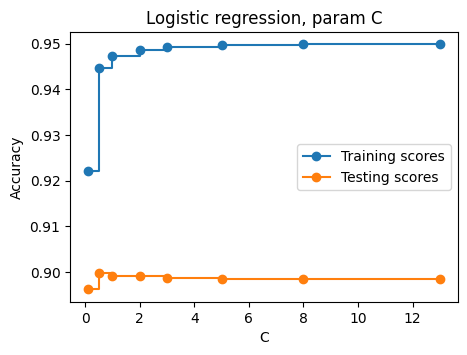

In [9]:
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm


paramC = [0.1, 0.5, 1, 2, 3, 5, 8, 13]
trainScores = np.zeros(len(paramC))
testScores = np.zeros(len(paramC))

for i, c in enumerate(tqdm(paramC)):
    m = LogisticRegression(C=c, penalty='l1', solver='saga', random_state=0, max_iter=1000)
    m.fit(X_train2_std, y_train2)
    
    trainScores[i] = m.score(X_train2_std, y_train2)
    testScores[i] = m.score(X_test2_std, y_test2)

showAccuracyComparisonPlot("Logistic regression, param C", 'C', 'Accuracy', paramC, trainScores, testScores, "Training scores", "Testing scores")

It seems that C between 0 and 2 is optimal. We'll do a grid search CV around this value.

In [14]:
from sklearn.model_selection import GridSearchCV


paramGrid = {
    'solver': ['liblinear', 'saga'],
    'C': [0.01, 0.1, 0.5, 1, 2, 3],
}

grid = GridSearchCV(LogisticRegression(penalty='l1', max_iter=5000), paramGrid, refit=True, verbose=3)
grid.fit(X_train2_std, y_train2)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END ..........C=0.01, solver=liblinear;, score=0.806 total time=   0.6s
[CV 2/5] END ..........C=0.01, solver=liblinear;, score=0.820 total time=   0.5s
[CV 3/5] END ..........C=0.01, solver=liblinear;, score=0.783 total time=   0.5s
[CV 4/5] END ..........C=0.01, solver=liblinear;, score=0.819 total time=   0.4s
[CV 5/5] END ..........C=0.01, solver=liblinear;, score=0.804 total time=   0.4s
[CV 1/5] END ...............C=0.01, solver=saga;, score=0.802 total time=  19.4s
[CV 2/5] END ...............C=0.01, solver=saga;, score=0.826 total time=  18.9s
[CV 3/5] END ...............C=0.01, solver=saga;, score=0.786 total time=  15.7s
[CV 4/5] END ...............C=0.01, solver=saga;, score=0.828 total time=  15.4s
[CV 5/5] END ...............C=0.01, solver=saga;, score=0.804 total time=  17.6s
[CV 1/5] END ...........C=0.1, solver=liblinear;, score=0.890 total time=   0.8s
[CV 2/5] END ...........C=0.1, solver=liblinear;

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ................C=0.5, solver=saga;, score=0.900 total time= 1.5min


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ................C=0.5, solver=saga;, score=0.909 total time= 1.5min


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ................C=0.5, solver=saga;, score=0.887 total time= 1.5min


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ................C=0.5, solver=saga;, score=0.909 total time= 1.5min


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END ................C=0.5, solver=saga;, score=0.875 total time= 1.5min
[CV 1/5] END .............C=1, solver=liblinear;, score=0.894 total time=   4.0s
[CV 2/5] END .............C=1, solver=liblinear;, score=0.893 total time=   3.4s
[CV 3/5] END .............C=1, solver=liblinear;, score=0.892 total time=   3.6s
[CV 4/5] END .............C=1, solver=liblinear;, score=0.902 total time=   3.2s
[CV 5/5] END .............C=1, solver=liblinear;, score=0.878 total time=   3.4s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ..................C=1, solver=saga;, score=0.892 total time= 1.6min


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ..................C=1, solver=saga;, score=0.903 total time= 1.6min


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ..................C=1, solver=saga;, score=0.884 total time= 1.6min


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ..................C=1, solver=saga;, score=0.905 total time= 1.5min


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END ..................C=1, solver=saga;, score=0.880 total time= 1.5min
[CV 1/5] END .............C=2, solver=liblinear;, score=0.887 total time=   4.7s
[CV 2/5] END .............C=2, solver=liblinear;, score=0.891 total time=   5.0s
[CV 3/5] END .............C=2, solver=liblinear;, score=0.884 total time=   6.4s
[CV 4/5] END .............C=2, solver=liblinear;, score=0.897 total time=   5.5s
[CV 5/5] END .............C=2, solver=liblinear;, score=0.877 total time=   4.9s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ..................C=2, solver=saga;, score=0.892 total time= 1.8min


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ..................C=2, solver=saga;, score=0.903 total time= 1.8min


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ..................C=2, solver=saga;, score=0.885 total time= 2.0min


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ..................C=2, solver=saga;, score=0.901 total time= 1.7min


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END ..................C=2, solver=saga;, score=0.877 total time= 1.7min
[CV 1/5] END .............C=3, solver=liblinear;, score=0.883 total time=   7.6s
[CV 2/5] END .............C=3, solver=liblinear;, score=0.882 total time=   8.4s
[CV 3/5] END .............C=3, solver=liblinear;, score=0.881 total time=  10.5s
[CV 4/5] END .............C=3, solver=liblinear;, score=0.897 total time=   8.7s
[CV 5/5] END .............C=3, solver=liblinear;, score=0.871 total time=   7.9s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END ..................C=3, solver=saga;, score=0.885 total time= 1.7min


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END ..................C=3, solver=saga;, score=0.901 total time= 1.7min


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END ..................C=3, solver=saga;, score=0.885 total time= 1.8min


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END ..................C=3, solver=saga;, score=0.900 total time= 1.8min


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END ..................C=3, solver=saga;, score=0.879 total time= 1.8min


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(estimator=LogisticRegression(max_iter=2000, penalty='l1'),
             param_grid={'C': [0.01, 0.1, 0.5, 1, 2, 3],
                         'solver': ['liblinear', 'saga']},
             verbose=3)

In [15]:
from sklearn.metrics import classification_report, confusion_matrix 


print('Best estimator:', grid.best_estimator_)
print('Best params:', grid.best_params_)
print('Best score from cross-validation:', grid.best_score_)

print('\nPerformance on unseen data:')
gridPredictions = grid.predict(X_test2_std)
print(classification_report(y_test2, gridPredictions))
# print(confusion_matrix(y_test2, gridPredictions))

Best estimator: LogisticRegression(C=0.5, max_iter=2000, penalty='l1', solver='saga')
Best params: {'C': 0.5, 'solver': 'saga'}
Best score from cross-validation: 0.8960000000000001

Performance on unseen data:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      3651
           1       0.93      0.97      0.95      4112
           2       0.87      0.89      0.88      3674
           3       0.87      0.86      0.87      3807
           4       0.90      0.91      0.90      3582
           5       0.85      0.85      0.85      3345
           6       0.94      0.92      0.93      3656
           7       0.91      0.91      0.91      3862
           8       0.88      0.82      0.85      3592
           9       0.89      0.88      0.88      3719

    accuracy                           0.90     37000
   macro avg       0.90      0.90      0.90     37000
weighted avg       0.90      0.90      0.90     37000



Test the recommended parameters + few variations.

In [21]:
m1 = LogisticRegression(solver='saga', C=0.1, max_iter=5000)
m2 = LogisticRegression(solver='saga', C=0.1, max_iter=5000, penalty='l1')
m3 = LogisticRegression(solver='saga', C=0.5, max_iter=5000, penalty='l1')

m1.fit(X_train2_std, y_train2)
m2.fit(X_train2_std, y_train2)
m3.fit(X_train2_std, y_train2)

print('M1 accuracy on unseen data:', m1.score(X_test2_std, y_test2))
print('M2 accuracy on unseen data:', m2.score(X_test2_std, y_test2))
print('M3 accuracy on unseen data:', m3.score(X_test2_std, y_test2))